In [1]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, max_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from eli5.sklearn import PermutationImportance
from joblib import load, dump
import eli5
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import category_encoders as ce
import pandas as pd

In [2]:
pd.set_option('display.max_columns', 100)
datapath = 'C:\\Users\\Nick\\LendingClub Project\\New\\Data\\'
df = pd.read_csv(datapath + 'clean_loan.csv')
print(df.shape)
df.head()

(1303638, 87)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,30000,30000,30000.0,36 months,22.35,1151.16,D,D5,Supervisor,5 years,MORTGAGE,100000.0,Source Verified,Dec-2018,Fully Paid,n,debt_consolidation,Debt consolidation,917xx,CA,30.46,0.0,Jan-2012,0.0,11.0,1.0,15603,37.0,19.0,w,0.0,0.0,30026.442500,30026.44,30000.0,26.44,0.0,0.0,0.0,Jan-2019,30082.32,Jan-2019,0.0,1,Joint App,0.0,0.0,472330.0,42200.0,4.0,42939.0,15181.0,46.9,0.0,0.0,83.0,73.0,23.0,2.0,1.0,23.0,8.0,0.0,3.0,4.0,3.0,5.0,10.0,6.0,8.0,4.0,11.0,0.0,0.0,0.0,2.0,89.5,33.3,1.0,0.0,527120.0,98453.0,28600.0,101984.0,N,Cash,N
1,40000,40000,40000.0,60 months,16.14,975.71,C,C4,Assistant to the Treasurer (Payroll),< 1 year,MORTGAGE,45000.0,Verified,Dec-2018,Fully Paid,n,credit_card,Credit card refinancing,456xx,OH,50.53,0.0,Jun-2009,0.0,18.0,0.0,34971,64.5,37.0,w,0.0,0.0,40856.678960,40856.68,40000.0,856.68,0.0,0.0,0.0,Feb-2019,40910.48,Feb-2019,0.0,1,Joint App,0.0,0.0,271068.0,54200.0,5.0,15059.0,14930.0,67.3,0.0,0.0,114.0,70.0,2.0,2.0,1.0,2.0,9.0,0.0,7.0,9.0,7.0,7.0,26.0,9.0,10.0,9.0,18.0,0.0,0.0,0.0,4.0,100.0,42.9,0.0,0.0,344802.0,161720.0,45700.0,167965.0,N,Cash,N
2,20000,20000,20000.0,36 months,7.56,622.68,A,A3,Teacher,10+ years,MORTGAGE,100000.0,Not Verified,Dec-2018,Fully Paid,n,credit_card,Credit card refinancing,982xx,WA,18.92,0.0,Feb-1999,0.0,9.0,0.0,25416,29.9,19.0,w,0.0,0.0,20215.792430,20215.79,20000.0,215.79,0.0,0.0,0.0,Feb-2019,20228.39,Feb-2019,0.0,1,Joint App,0.0,0.0,515779.0,85100.0,5.0,57309.0,59684.0,29.9,0.0,0.0,171.0,238.0,1.0,1.0,5.0,1.0,13.0,0.0,5.0,5.0,5.0,6.0,5.0,5.0,9.0,5.0,9.0,0.0,0.0,0.0,1.0,94.7,20.0,0.0,0.0,622183.0,71569.0,85100.0,74833.0,N,Cash,N
3,4500,4500,4500.0,36 months,11.31,147.99,B,B3,Accounts Examiner III,10+ years,RENT,38500.0,Not Verified,Dec-2018,Fully Paid,n,credit_card,Credit card refinancing,786xx,TX,4.64,0.0,Dec-2003,0.0,12.0,0.0,4472,15.3,25.0,w,0.0,0.0,4549.217149,4549.22,4500.0,49.22,0.0,0.0,0.0,Feb-2019,4553.46,Feb-2019,0.0,1,Individual,0.0,306.0,29137.0,29200.0,8.0,2428.0,10735.0,28.9,0.0,0.0,180.0,69.0,2.0,2.0,0.0,2.0,6.0,1.0,3.0,5.0,5.0,6.0,10.0,11.0,15.0,5.0,12.0,0.0,0.0,0.0,4.0,91.7,0.0,0.0,0.0,53795.0,29137.0,15100.0,24595.0,N,Cash,N
4,8425,8425,8425.0,36 months,27.27,345.18,E,E5,Senior Director Risk Management,3 years,MORTGAGE,450000.0,Verified,Dec-2018,Fully Paid,n,credit_card,Credit card refinancing,020xx,MA,12.37,0.0,Oct-1997,0.0,21.0,0.0,36812,65.7,37.0,w,0.0,0.0,8735.148975,8735.15,8425.0,310.15,0.0,0.0,0.0,Feb-2019,8754.30,Feb-2019,0.0,1,Joint App,0.0,0.0,690320.0,56000.0,10.0,34516.0,11632.0,74.6,0.0,0.0,254.0,89.0,12.0,12.0,4.0,18.0,4.0,0.0,6.0,8.0,8.0,10.0,16.0,13.0,17.0,8.0,21.0,0.0,0.0,0.0,2.0,100.0,50.0,0.0,0.0,768304.0,189194.0,45800.0,189054.0,N,Cash,N


In [3]:
def wrangle(dataframe):
    feats = ['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 
    'annual_inc', 'verification_status', 'issue_d', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 
    'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_bal_ex_mort',
    'total_bc_limit', 'mo_sin_old_il_acct','mo_sin_old_rev_tl_op', 'num_accts_ever_120_pd', 'num_sats', 'total_pymnt_inv', 'funded_amnt_inv']

    # Features to fillna with 0
    na_fill = ['emp_length', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'num_accts_ever_120_pd', 'num_sats', 
    'revol_util', 'dti', 'inq_last_6mths', 'total_bal_ex_mort', 'total_bc_limit']
    
    # DF to work with
    x = dataframe[feats].copy()
    
    # Remove loans that had no investments
    x = x[x['funded_amnt_inv'] != 0]
    
    # Create ROI and Return features
    x['Return'] = x['total_pymnt_inv'] - x['funded_amnt_inv']
    x['ROI'] = (x['Return']/x['funded_amnt_inv']*100)   

    # Drop income outliers
    x = x[(x['annual_inc'] > 10000) & (x['annual_inc'] < 500000)]

    # Fix date time 
    x['days_since_earliest_cr_line'] = (pd.to_datetime(x['issue_d']) - pd.to_datetime(x['earliest_cr_line'])).dt.days
    
    # Fill nans
    x[na_fill] = x[na_fill].fillna(0)
   
    # Cat encode categorical features and remove other columns
    encoder = ce.OrdinalEncoder()
    x = encoder.fit_transform(x.drop(columns=['issue_d', 'earliest_cr_line', 'total_pymnt_inv', 'funded_amnt_inv']))
    
    return x

In [4]:
x = wrangle(df)
x.shape

(1299618, 31)

In [5]:
x.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_bal_ex_mort,total_bc_limit,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,num_accts_ever_120_pd,num_sats,Return,ROI,days_since_earliest_cr_line
0,30000,1,22.35,1151.16,1,1,1,1,100000.0,1,1,1,1,1,30.46,0.0,0.0,11.0,1.0,15603,37.0,19.0,98453.0,28600.0,83.0,73.0,0.0,11.0,26.44,0.088133,2526
1,40000,2,16.14,975.71,2,2,2,1,45000.0,2,2,2,2,2,50.53,0.0,0.0,18.0,0.0,34971,64.5,37.0,161720.0,45700.0,114.0,70.0,0.0,18.0,856.68,2.141700,3470
2,20000,1,7.56,622.68,3,3,3,1,100000.0,3,2,2,3,3,18.92,0.0,0.0,9.0,0.0,25416,29.9,19.0,71569.0,85100.0,171.0,238.0,0.0,9.0,215.79,1.078950,7243
3,4500,1,11.31,147.99,4,4,3,2,38500.0,3,2,2,4,4,4.64,0.0,0.0,12.0,0.0,4472,15.3,25.0,29137.0,15100.0,180.0,69.0,1.0,12.0,49.22,1.093778,5479
4,8425,1,27.27,345.18,5,5,4,1,450000.0,2,2,2,5,5,12.37,0.0,0.0,21.0,0.0,36812,65.7,37.0,189194.0,45800.0,254.0,89.0,0.0,21.0,310.15,3.681306,7731


In [6]:
# feats = ['int_rate', 'term', 'sub_grade', 'loan_amnt', 'annual_inc', 'installment']
drop = ['Return', 'ROI']
target = 'ROI'
train, test = train_test_split(x, random_state=42)
train.shape, test.shape

((974713, 31), (324905, 31))

In [7]:
small_train, small_val = train_test_split(train.sample(10000, random_state=42), random_state=42)
small_train.shape, small_val.shape

((7500, 31), (2500, 31))

In [8]:
X_small_train = small_train.drop(drop, axis=1)
X_small_val = small_val.drop(drop, axis=1)
y_small_train = small_train[target]
y_small_val = small_val[target]

In [9]:
baseline_prediction = small_train['ROI'].mean()
base_pred = [baseline_prediction]*len(y_small_val)
print(f'Baseline MAE: {mean_absolute_error(base_pred, y_small_val)}')

Baseline MAE: 20.001037505776097


In [10]:
rfr_pipe= make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=42, n_jobs=-1)
)

params_rfr = {
    'randomforestregressor__max_depth' : [2,4,6,10,20,None],
    'randomforestregressor__n_estimators' : st.randint(1, 2000),
    'randomforestregressor__max_features' : st.uniform()
}
search = RandomizedSearchCV(
    rfr_pipe, 
    param_distributions=params_rfr, 
    n_iter=10, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
search.fit(X_small_train, y_small_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:  2.8min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:  2.8min remaining:   59.8s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:  2.9min remaining:   28.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('standardscaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('randomforestregressor',
                                              RandomForestRegressor(bootstrap=True,
                                                                    criterion='mse',
                                                                    max_depth=None,
                                                                    max_features='auto',
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
   

In [11]:
rfr_search = search.best_estimator_
rfr_pred = rfr_search.predict(X_small_val)

In [12]:
print(f'RFR Val MAE: {mean_absolute_error(rfr_pred, y_small_val)}')
print(f'Baseline MAE: {mean_absolute_error(base_pred, y_small_val)}')
print(f'Improvement over Baseline for Random Forest Regression: {mean_absolute_error(base_pred, y_small_val)-mean_absolute_error(rfr_pred, y_small_val)}')

RFR Val MAE: 19.46089566971158
Baseline MAE: 20.001037505776097
Improvement over Baseline for Random Forest Regression: 0.5401418360645174


Not great! Let's still take a look inside

In [13]:
feat_importance = pd.DataFrame({
    'Feature': X_small_val.columns.tolist(),
    'Importance': rfr_search.named_steps['randomforestregressor'].feature_importances_.tolist()
}).sort_values(by='Importance', ascending=False)
feat_importance

,Feature,Importance
2,int_rate,0.183231
11,title,0.117463
5,emp_title,0.073881
14,dti,0.050530
19,revol_bal,0.041216
23,total_bc_limit,0.040660
25,mo_sin_old_rev_tl_op,0.039470
28,days_since_earliest_cr_line,0.038859
20,revol_util,0.037992
4,sub_grade,0.035928


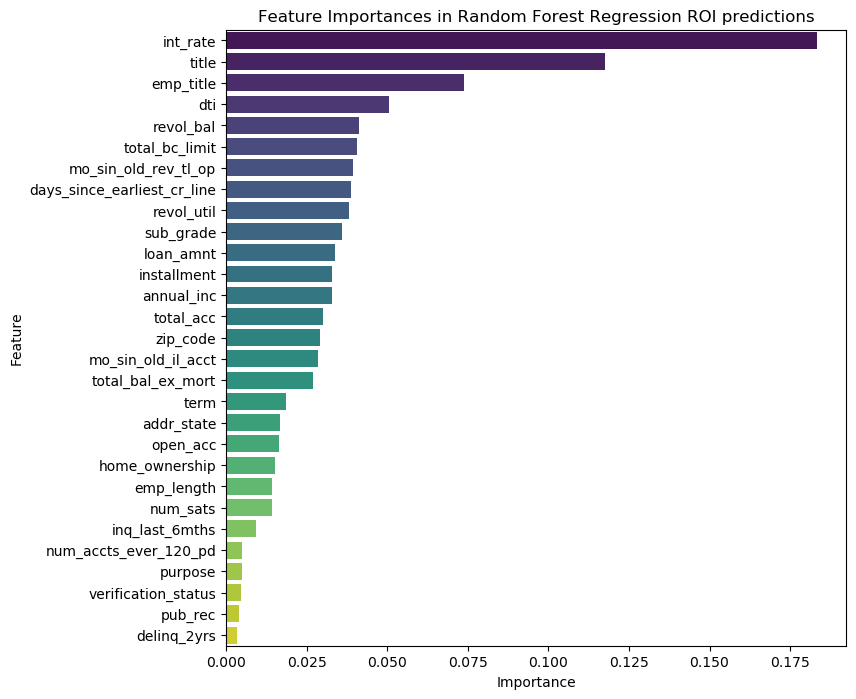

In [14]:
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.barplot(data=feat_importance, y='Feature', x='Importance', palette='viridis')
    ax.set_title('Feature Importances in Random Forest Regression ROI predictions')

In [17]:
plotter = pd.DataFrame({'Predicted ROI':rfr_pred.tolist(), 'True ROI':y_small_val.tolist(), 'Baseline Prediction':base_pred})
plotter.head()

,Predicted ROI,True ROI,Baseline Prediction
0,-0.940533,16.632511,3.198883
1,3.851273,10.712000,3.198883
2,11.731913,23.321446,3.198883
3,1.074904,-35.661520,3.198883
4,0.357726,25.310000,3.198883


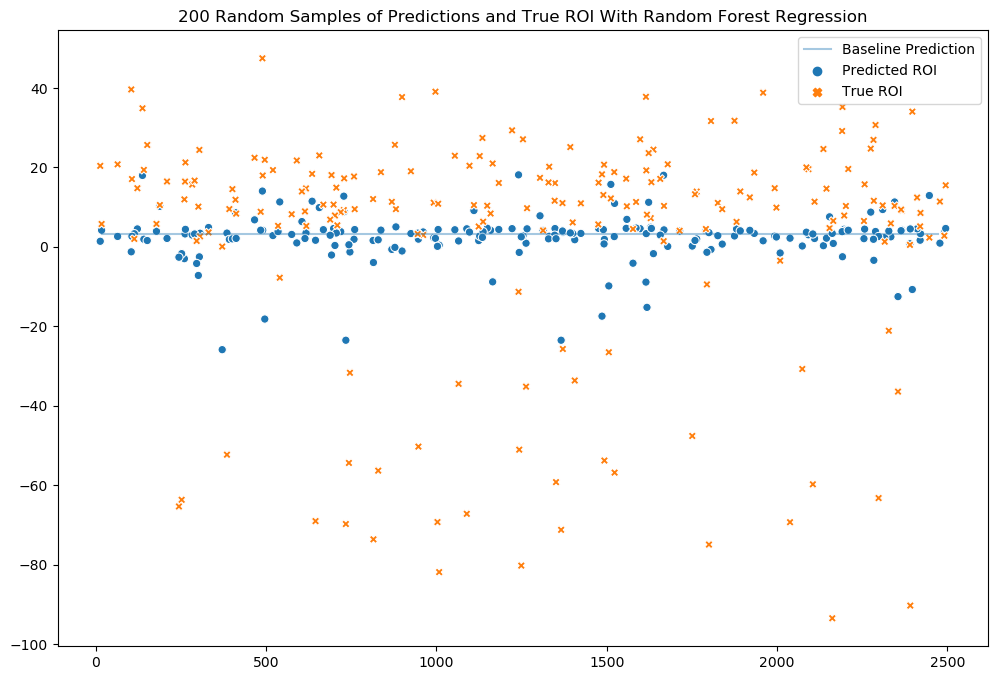

In [22]:
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(12,8))
    sns.scatterplot(data=plotter[['Predicted ROI', 'True ROI']].sample(200))
    sns.lineplot(data=plotter['Baseline Prediction'].sample(200), alpha=.4, ax=ax, label='Baseline Prediction')
    plt.title('200 Random Samples of Predictions and True ROI With Random Forest Regression')
    plt.show()

In [35]:
feature_names = X_small_val.columns.tolist()

permute = PermutationImportance(
    rfr_search,
    scoring='neg_mean_absolute_error',
    n_iter=3,
    random_state=42
)
permute.fit(X_small_val, y_small_val)

eli5.show_weights(
    permute,
    top=None, #show permutation importances for top n features, none=all
    feature_names=feature_names,
)

Weight,Feature
0.3186 ± 0.0337,int_rate
0.1962 ± 0.0172,title
0.1141 ± 0.0310,mo_sin_old_rev_tl_op
0.1014 ± 0.0181,term
0.0494 ± 0.0192,home_ownership
0.0429 ± 0.0196,sub_grade
0.0403 ± 0.0198,installment
0.0395 ± 0.0120,dti
0.0338 ± 0.0172,loan_amnt
0.0325 ± 0.0096,total_bal_ex_mort


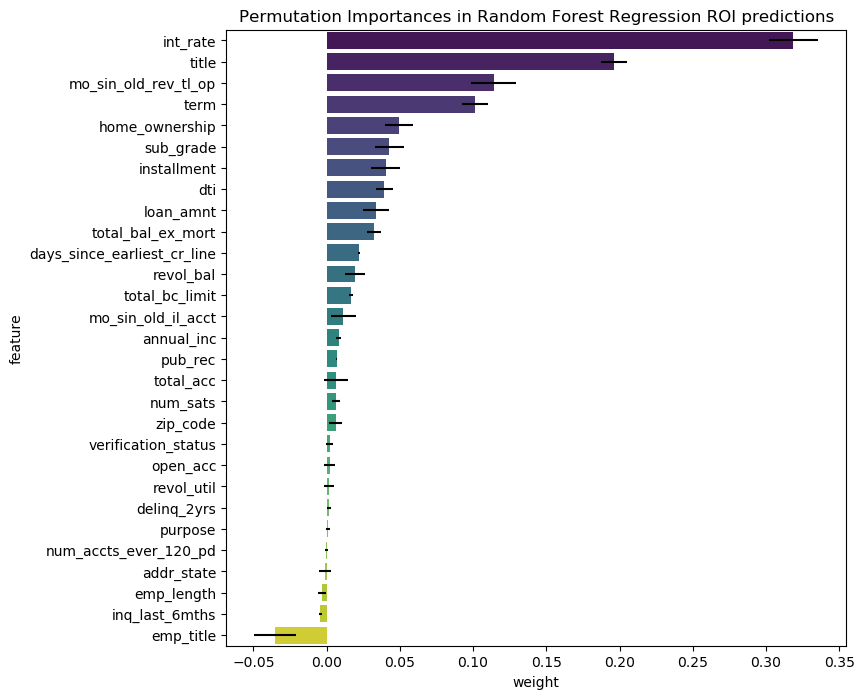

In [37]:
perm_import = eli5.explain_weights_df(permute, top=None, feature_names=feature_names)
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.barplot(data=perm_import, y='feature', x='weight', palette='viridis', xerr=perm_import['std'])
    ax.set_title('Permutation Importances in Random Forest Regression ROI predictions')

# Working with LGBMRegressor and GridSearchCV

In [203]:
x.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_bal_ex_mort,total_bc_limit,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,num_accts_ever_120_pd,num_sats,Return,ROI,days_since_earliest_cr_line
0,30000,1,22.35,1151.16,1,1,1,1,100000.0,1,1,1,1,1,30.46,0.0,0.0,11.0,1.0,15603,37.0,19.0,98453.0,28600.0,83.0,73.0,0.0,11.0,26.44,0.088133,2526
1,40000,2,16.14,975.71,2,2,2,1,45000.0,2,2,2,2,2,50.53,0.0,0.0,18.0,0.0,34971,64.5,37.0,161720.0,45700.0,114.0,70.0,0.0,18.0,856.68,2.141700,3470
2,20000,1,7.56,622.68,3,3,3,1,100000.0,3,2,2,3,3,18.92,0.0,0.0,9.0,0.0,25416,29.9,19.0,71569.0,85100.0,171.0,238.0,0.0,9.0,215.79,1.078950,7243
3,4500,1,11.31,147.99,4,4,3,2,38500.0,3,2,2,4,4,4.64,0.0,0.0,12.0,0.0,4472,15.3,25.0,29137.0,15100.0,180.0,69.0,1.0,12.0,49.22,1.093778,5479
4,8425,1,27.27,345.18,5,5,4,1,450000.0,2,2,2,5,5,12.37,0.0,0.0,21.0,0.0,36812,65.7,37.0,189194.0,45800.0,254.0,89.0,0.0,21.0,310.15,3.681306,7731


In [62]:
# features = ['int_rate', 'term', 'sub_grade', 'loan_amnt', 'delinq_2yrs', 'revol_util', 'annual_inc', 'installment', 'num_sats', 'dti', 'open_acc', 'num_accts_ever_120_pd']
features = ['int_rate', 'term', 'sub_grade', 'loan_amnt', 'annual_inc', 'installment']
X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]
X_train.shape, X_test.shape

((974713, 6), (324905, 6))

In [63]:
base_pred1 = [train['ROI'].mean()] * len(test)
print(f'Baseline MAE for Test data: {mean_absolute_error(base_pred1, y_test)}')

Baseline MAE for Test data: 20.223643467120777


In [98]:
lgbm_pipe = make_pipeline(
    StandardScaler(),
    LGBMRegressor(random_state=42, n_jobs=-1)
)
params = {
    'lgbmregressor__max_depth' : [0,5,10,20, 25],
    'lgbmregressor__n_estimators' : [100, 300, 500, 1000, 1500, 2000],
    'lgbmregressor__learning_rate' : [.05, .1, .15, .2],
    'lgbmregressor__objective' : ['l1'],
    'lgbmregressor__boosting' : ['goss'],    
}
searcher = GridSearchCV(
    lgbm_pipe,
    param_grid = params,
    scoring= 'neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    verbose = 10,
    return_train_score=True,
)
searcher.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed: 50.2min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 54.4min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed: 63.5min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 70.3min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed: 77.1min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed: 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lgbmregressor',
                                        LGBMRegressor(boosting_type='gbdt',
                                                      class_weight=None,
                                                      colsample_bytree=1.0,
                                                      importance_type='split',
                                                      learning_rate=0.1,
                                                      max_depth=-1,
                                                      min_child_samples=20,
                                                      min_

In [99]:
searcher.best_score_, searcher.best_params_

(-16.76252336081959,
 {'lgbmregressor__boosting': 'goss',
  'lgbmregressor__learning_rate': 0.1,
  'lgbmregressor__max_depth': 5,
  'lgbmregressor__n_estimators': 1500,
  'lgbmregressor__objective': 'l1'})

In [100]:
lgbm_search = searcher.best_estimator_
lgbm_pred = lgbm_search.predict(X_test)
print(f'LGBM Test MAE: {mean_absolute_error(lgbm_pred, y_test)}')
print(f'Baseline MAE for Test data: {mean_absolute_error(base_pred1, y_test)}')
print(f'Improvement over Baseline for Light GBM Regression: {mean_absolute_error(base_pred1, y_test)-mean_absolute_error(lgbm_pred, y_test)}')

LGBM Test MAE: 16.685289066414494
Baseline MAE for Test data: 20.223643467120777
Improvement over Baseline for Light GBM Regression: 3.5383544007062824


Not the BEST but pretty good score!!!

In [106]:
plotter1 = pd.DataFrame({'Predicted ROI':lgbm_pred.tolist(), 'True ROI':y_test.tolist(), 'Baseline Prediction':base_pred1})
plotter1.head()

,Predicted ROI,True ROI,Baseline Prediction
0,12.279319,13.349625,3.159826
1,10.681398,7.939333,3.159826
2,20.086384,0.224267,3.159826
3,13.538457,5.408500,3.159826
4,20.145107,25.640714,3.159826


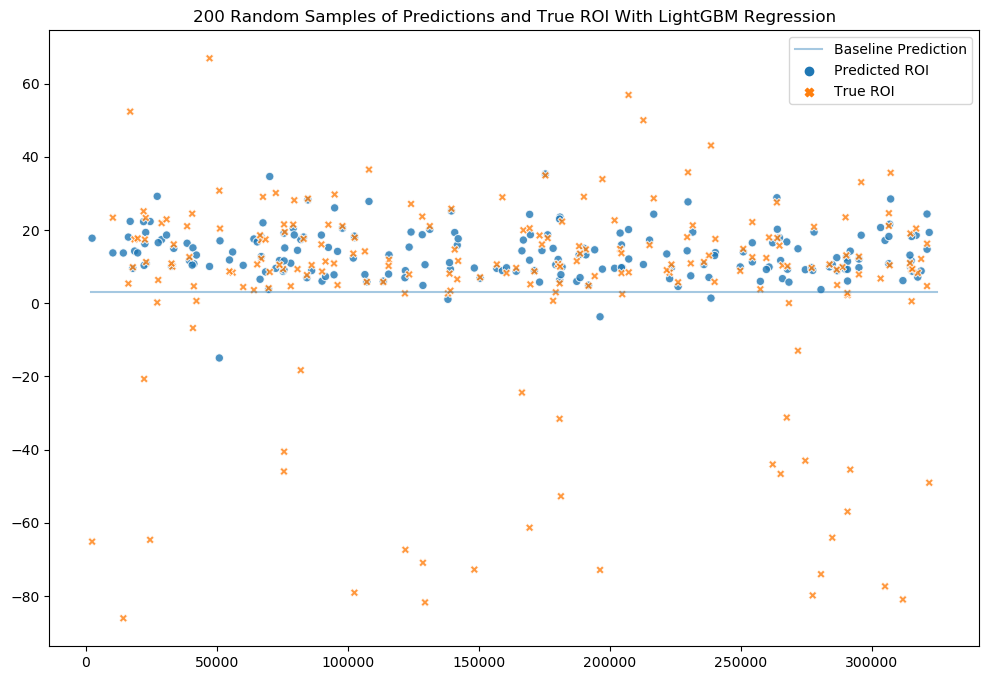

In [107]:
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(12,8))
    sns.scatterplot(data=plotter1[['Predicted ROI', 'True ROI']].sample(200), alpha=.8, ax=ax)
    sns.lineplot(data=plotter1['Baseline Prediction'].sample(200), alpha=.4, ax=ax, label='Baseline Prediction')
    plt.title('200 Random Samples of Predictions and True ROI With LightGBM Regression')
    plt.show()

In [108]:
lgbm_search.named_steps['lgbmregressor'].feature_importances_

array([11858,   893,  5182,  6189,  9448,  6031])

In [109]:
feat_importance = pd.DataFrame({
    'Feature': X_test.columns.tolist(),
    'Importance': lgbm_search.named_steps['lgbmregressor'].feature_importances_.tolist()
}).sort_values(by='Importance', ascending=False)
feat_importance

,Feature,Importance
0,int_rate,11858
4,annual_inc,9448
3,loan_amnt,6189
5,installment,6031
2,sub_grade,5182
1,term,893


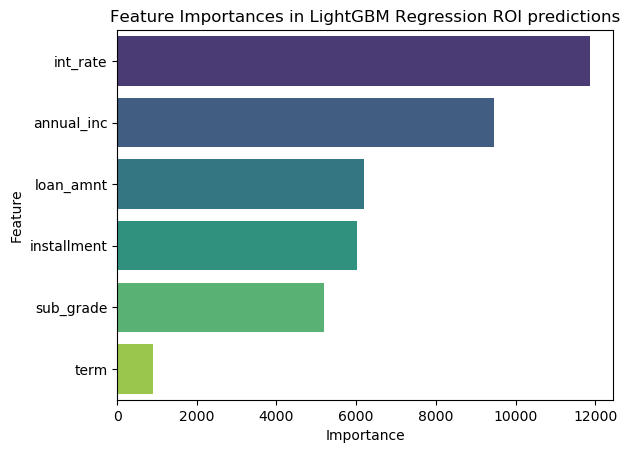

In [110]:
with plt.style.context('default'):
    fig, ax = plt.subplots()
    sns.barplot(data=feat_importance, y='Feature', x='Importance', palette='viridis')
    ax.set_title('Feature Importances in LightGBM Regression ROI predictions')

In [111]:
feature_names1 = X_test.columns.tolist()

permuter = PermutationImportance(
    lgbm_search,
    scoring='neg_mean_absolute_error',
    n_iter=3,
    random_state=42
)
permuter.fit(X_test, y_test)

eli5.show_weights(
    permuter,
    top=None, #show permutation importances for top n features, none=all
    feature_names=feature_names1,
)

Weight,Feature
2.9135 ± 0.0034,int_rate
2.8953 ± 0.0070,installment
2.0756 ± 0.0229,loan_amnt
1.0060 ± 0.0079,sub_grade
0.4240 ± 0.0083,term
0.0986 ± 0.0099,annual_inc


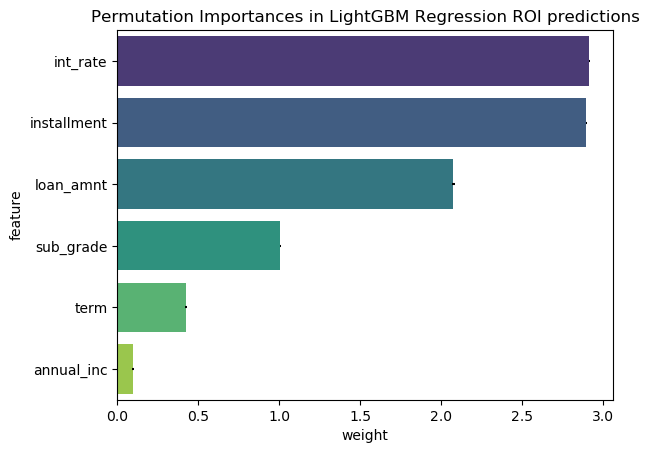

In [112]:
perm_importance = eli5.explain_weights_df(permuter, top=None, feature_names=feature_names1)
with plt.style.context('default'):
    fig, ax = plt.subplots()
    sns.barplot(data=perm_importance, y='feature', x='weight', palette='viridis', xerr=perm_importance['std'])
    ax.set_title('Permutation Importances in LightGBM Regression ROI predictions')

In [102]:
dump(lgbm_search, 'lgbm_pipeline.joblib', compress=True)

['lgbm_pipeline.joblib']

In [103]:
pipe_test = load('lgbm_pipeline.joblib')

In [114]:
pickle_pred = pipe_test.predict(X_test)
print(f'Test MAE: {mean_absolute_error(y_test, pickle_pred)}')

Test MAE: 16.685289066414494


In [122]:
import joblib
import sklearn
import lightgbm
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'lightgbm=={lightgbm.__version__}')

joblib==0.14.0
scikit-learn==0.21.3
lightgbm==2.3.0
